In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#pm.help()
#pm.reset()
#pm.init() #debug=True)
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
#cr_cp.info()
#fe_cp.info()

df_jo = pm.df('df_jo')
#df_jo.info()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])

#df_jo = df_jo.drop(columns=['Mes_created_at'])
df_jo_cp = df_jo.copy()

df_jo_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   active                      32092 non-null  int64          
 5   created_at                  32092 non-null  datetime64[ns] 
 6   created_at_fe               21055 non-null  datetime64[ns] 
 7   amount                      32092 non-null  float64        
 8   fee                         21055 non-null  float64        
 9   stat_cr                     32092 non-null  object         
 10  stat_fe                     32092 non-null  object         
 11  transfer_type               32092 non-nul

In [3]:
# Contar registros por categoría, incluyendo nulos
status_counts = df_jo['recovery_status'].value_counts(dropna=False)

# Mostrar el conteo
print(status_counts)


recovery_status
nice                    24893
completed                5166
pending                  1996
pending_direct_debit       36
cancelled                   1
Name: count, dtype: int64


In [4]:
# Asegúrate de que 'created_at' sea de tipo datetime
df_jo['created_at'] = pd.to_datetime(df_jo['created_at'])


In [5]:
df_jo_prueba_reco=df_jo.copy()

# Crear una columna de año-mes
df_jo_prueba_reco['year_month'] = df_jo_prueba_reco['created_at'].dt.to_period('M')

# Agrupar por año-mes y estado de recuperación
status_distribution = df_jo_prueba_reco.groupby(['year_month', 'recovery_status']).size().unstack()

# Mostrar los primeros registros
print(status_distribution.head(16))


recovery_status  cancelled  completed    nice  pending  pending_direct_debit
year_month                                                                  
2019-11                NaN        NaN     1.0      NaN                   NaN
2019-12                NaN       14.0   250.0     24.0                   1.0
2020-01                NaN       24.0   190.0      9.0                   NaN
2020-02                NaN        6.0   168.0     10.0                   NaN
2020-03                NaN       15.0   226.0      2.0                   1.0
2020-04                NaN       45.0   414.0     14.0                   NaN
2020-05                NaN      183.0   780.0     34.0                   NaN
2020-06                NaN      690.0  2692.0    280.0                   NaN
2020-07                NaN      728.0  3654.0    403.0                   7.0
2020-08                NaN     1059.0  3846.0    333.0                  11.0
2020-09                NaN     1107.0  4733.0    378.0                   9.0

In [ ]:
pd.set_option('display.max_columns', None)
df_jo[df_jo['recovery_status']=='cancelled'] # la unica en cancelled

,id_cr,id_fe,fe_cr_id,user_id,active,created_at,created_at_fe,amount,fee,stat_cr,stat_fe,transfer_type,type,to_receive_ini,to_receive_bank,to_reimbur,to_reimbur_cash,to_end,to_send,send_at,cr_received_date,money_back_date,reimbursement_date,paid_at,charge_moment,moderated_at,reason,category,from_date,to_date,recovery_status,updated_at,reco_creation,reco_last_update,updated_at_fe,Mes_created_at,cash_request_received_date,n_fees,n_backs,n_recovery,created_at_slot,created_at_slot_h,created_at_dow,needs_m_check,needs_m_check_recov
28073,23127,16008,23127.0,83479,1,2020-10-22 15:45:55.449352,2020-10-22 15:46:17.351076,100.0,5.0,transaction_declined,cancelled,instant,instant_payment,NaT,NaT,10 days 08:05:04.550648,10 days 08:04:47,-7 days +01:25:46,0 days 00:00:17.550648,2020-10-22 15:46:13,NaT,2020-11-08 22:25:14,2020-11-01 23:51:00,2020-11-05 14:03:12,after,NaT,Instant Payment Cash Request 23127,nice,NaT,NaT,cancelled,2020-12-23 17:31:58.564319,2020-11-08 22:25:11.155135,2021-01-04 11:09:57.813744,2021-01-04 11:09:21.690816,2020-10,NaT,0,0,1,14,15-Tarde,3,1,1


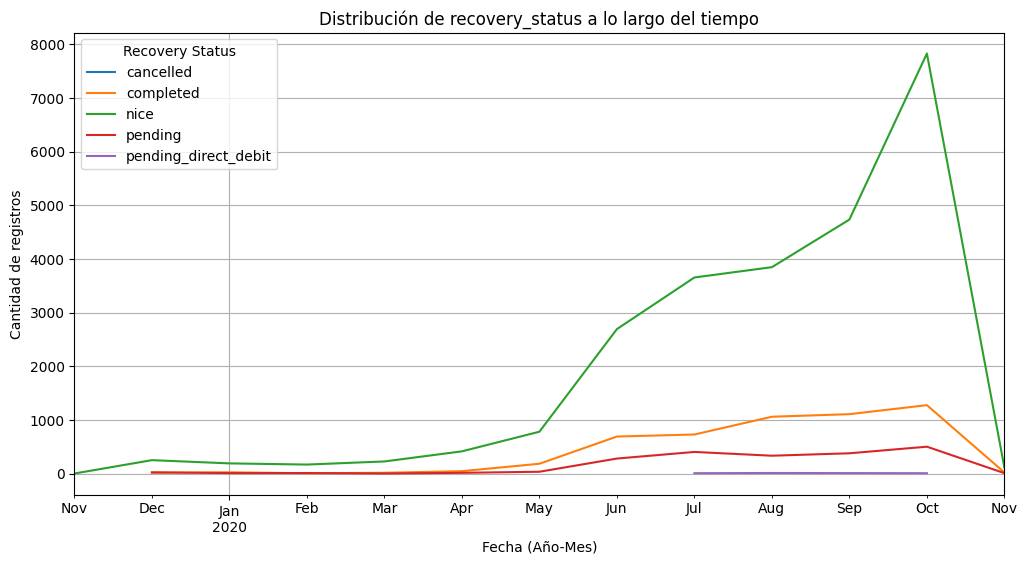

In [6]:
import matplotlib.pyplot as plt

# Graficar la distribución
status_distribution.plot(kind='line', figsize=(12, 6))
plt.title('Distribución de recovery_status a lo largo del tiempo')
plt.xlabel('Fecha (Año-Mes)')
plt.ylabel('Cantidad de registros')
plt.legend(title='Recovery Status')
plt.grid()
plt.show()


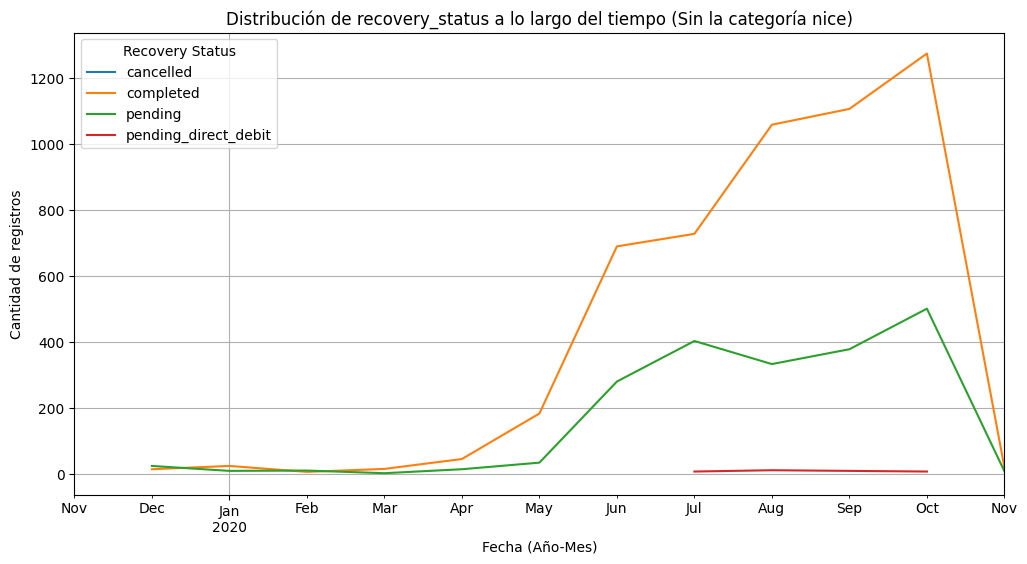

In [11]:
# Filtrar la categoría más frecuente ('nice') para que no queden aplanadas las otras tres

most_frequent_category = status_distribution.sum(axis=0).idxmax()  # Categoría más frecuente
status_distribution_filtered = status_distribution.drop(columns=most_frequent_category)

# Graficar la distribución sin la categoría más frecuente
status_distribution_filtered.plot(kind='line', figsize=(12, 6))
plt.title('Distribución de recovery_status a lo largo del tiempo (Sin la categoría nice)')
plt.xlabel('Fecha (Año-Mes)')
plt.ylabel('Cantidad de registros')
plt.legend(title='Recovery Status')
plt.grid(True)
plt.show()


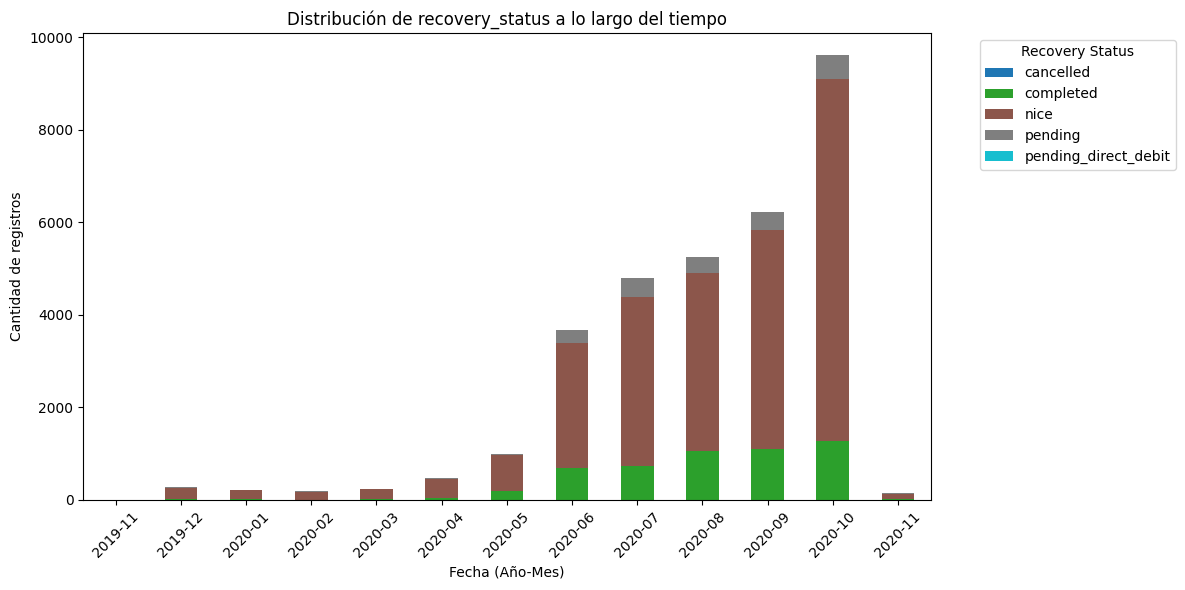

In [7]:
# Gráfico de barras apiladas
status_distribution.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10')
plt.title('Distribución de recovery_status a lo largo del tiempo')
plt.xlabel('Fecha (Año-Mes)')
plt.ylabel('Cantidad de registros')
plt.legend(title='Recovery Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


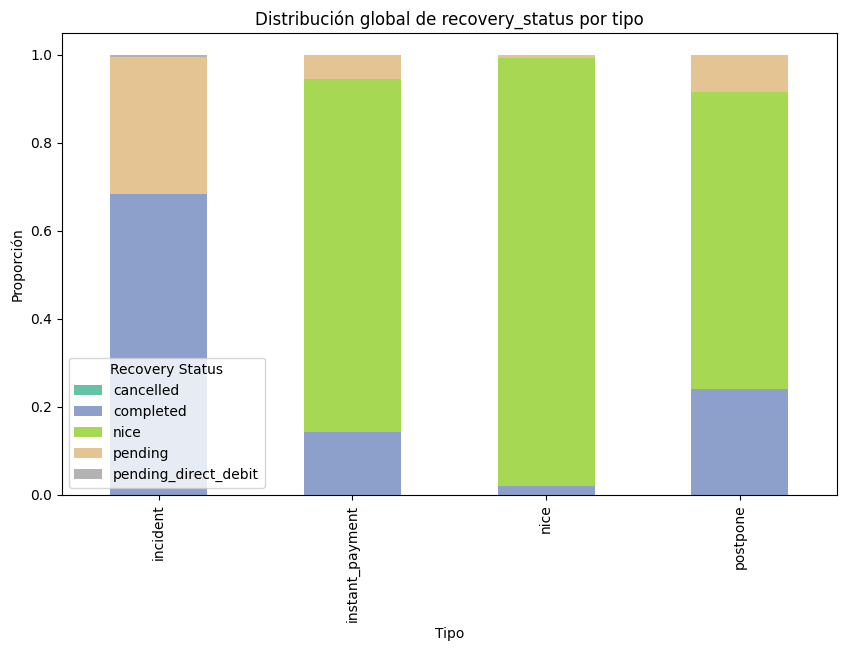

In [14]:
# Distribución global de recovery_status por tipo
type_distribution = df_jo.groupby('type')['recovery_status'].value_counts(normalize=True).unstack()

# Visualizar
type_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title('Distribución global de recovery_status por tipo')
plt.xlabel('Tipo')
plt.ylabel('Proporción')
plt.legend(title='Recovery Status')
plt.show()


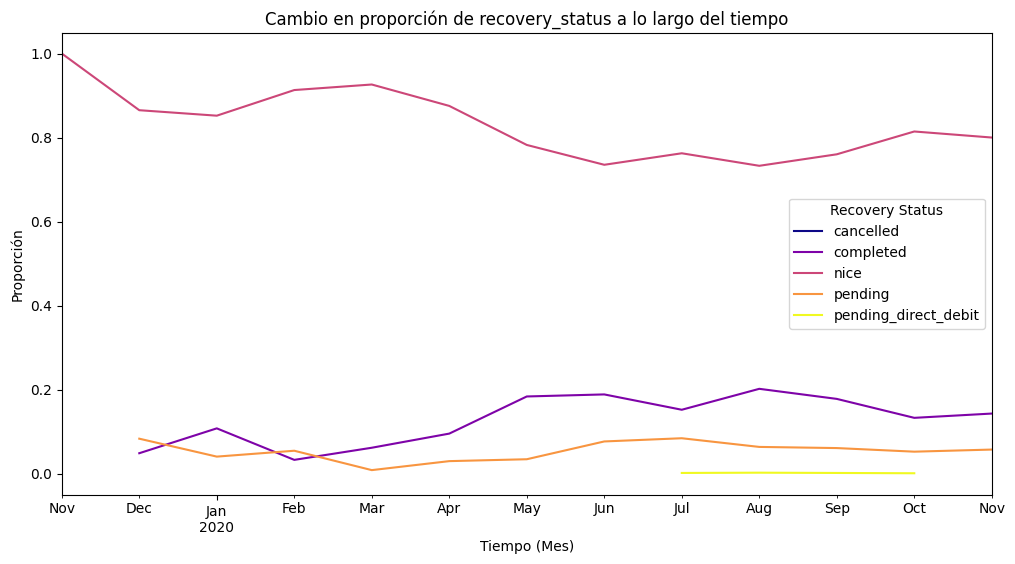

In [15]:
# Distribución temporal de recovery_status
df_jo['created_at'] = pd.to_datetime(df_jo['created_at'])
temporal_status = df_jo.groupby(df_jo['created_at'].dt.to_period('M'))['recovery_status'].value_counts(normalize=True).unstack()

# Visualizar
temporal_status.plot(kind='line', figsize=(12, 6), colormap='plasma')
plt.title('Cambio en proporción de recovery_status a lo largo del tiempo')
plt.xlabel('Tiempo (Mes)')
plt.ylabel('Proporción')
plt.legend(title='Recovery Status')
plt.show()
